In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve, f1_score 
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load and Inspect Data

In [2]:
df_load = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
total_columns = len(df_load.columns)
half_column = total_columns // 2

In [4]:
df_load.iloc[:, :half_column].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No


In [5]:
df_load.iloc[:, half_column:].head()

,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df_load['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

# Understand the Data

In [7]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Descriptive Statistics:

In [8]:
df_load.iloc[:, :half_column].describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN


In [9]:
df_load.iloc[:, half_column:].describe(include='all')

,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,3,3,3,3,3,3,2,4,NaN,6531,2
top,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


# Data Cleaning

### Check for Missing Values

In [10]:
df_load.isnull().sum().tolist()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Convert to Categorical

In [11]:
df = df_load.copy()
cols_to_convert = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                   'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                   'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

for col in cols_to_convert:
    df[col] = df[col].astype('category')

### Convert `TotalCharges` to a Float

In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

### Convert the Target `Churn` to `Churn_binary` for Correlation Analysis

In [13]:
df['Churn_binary'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['Churn_binary'] = df['Churn_binary'].astype('int64')

### Reset `SeniorCitzen` to `int64`

In [14]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('int64')

# Data Visualiziation

### Review Target by Category

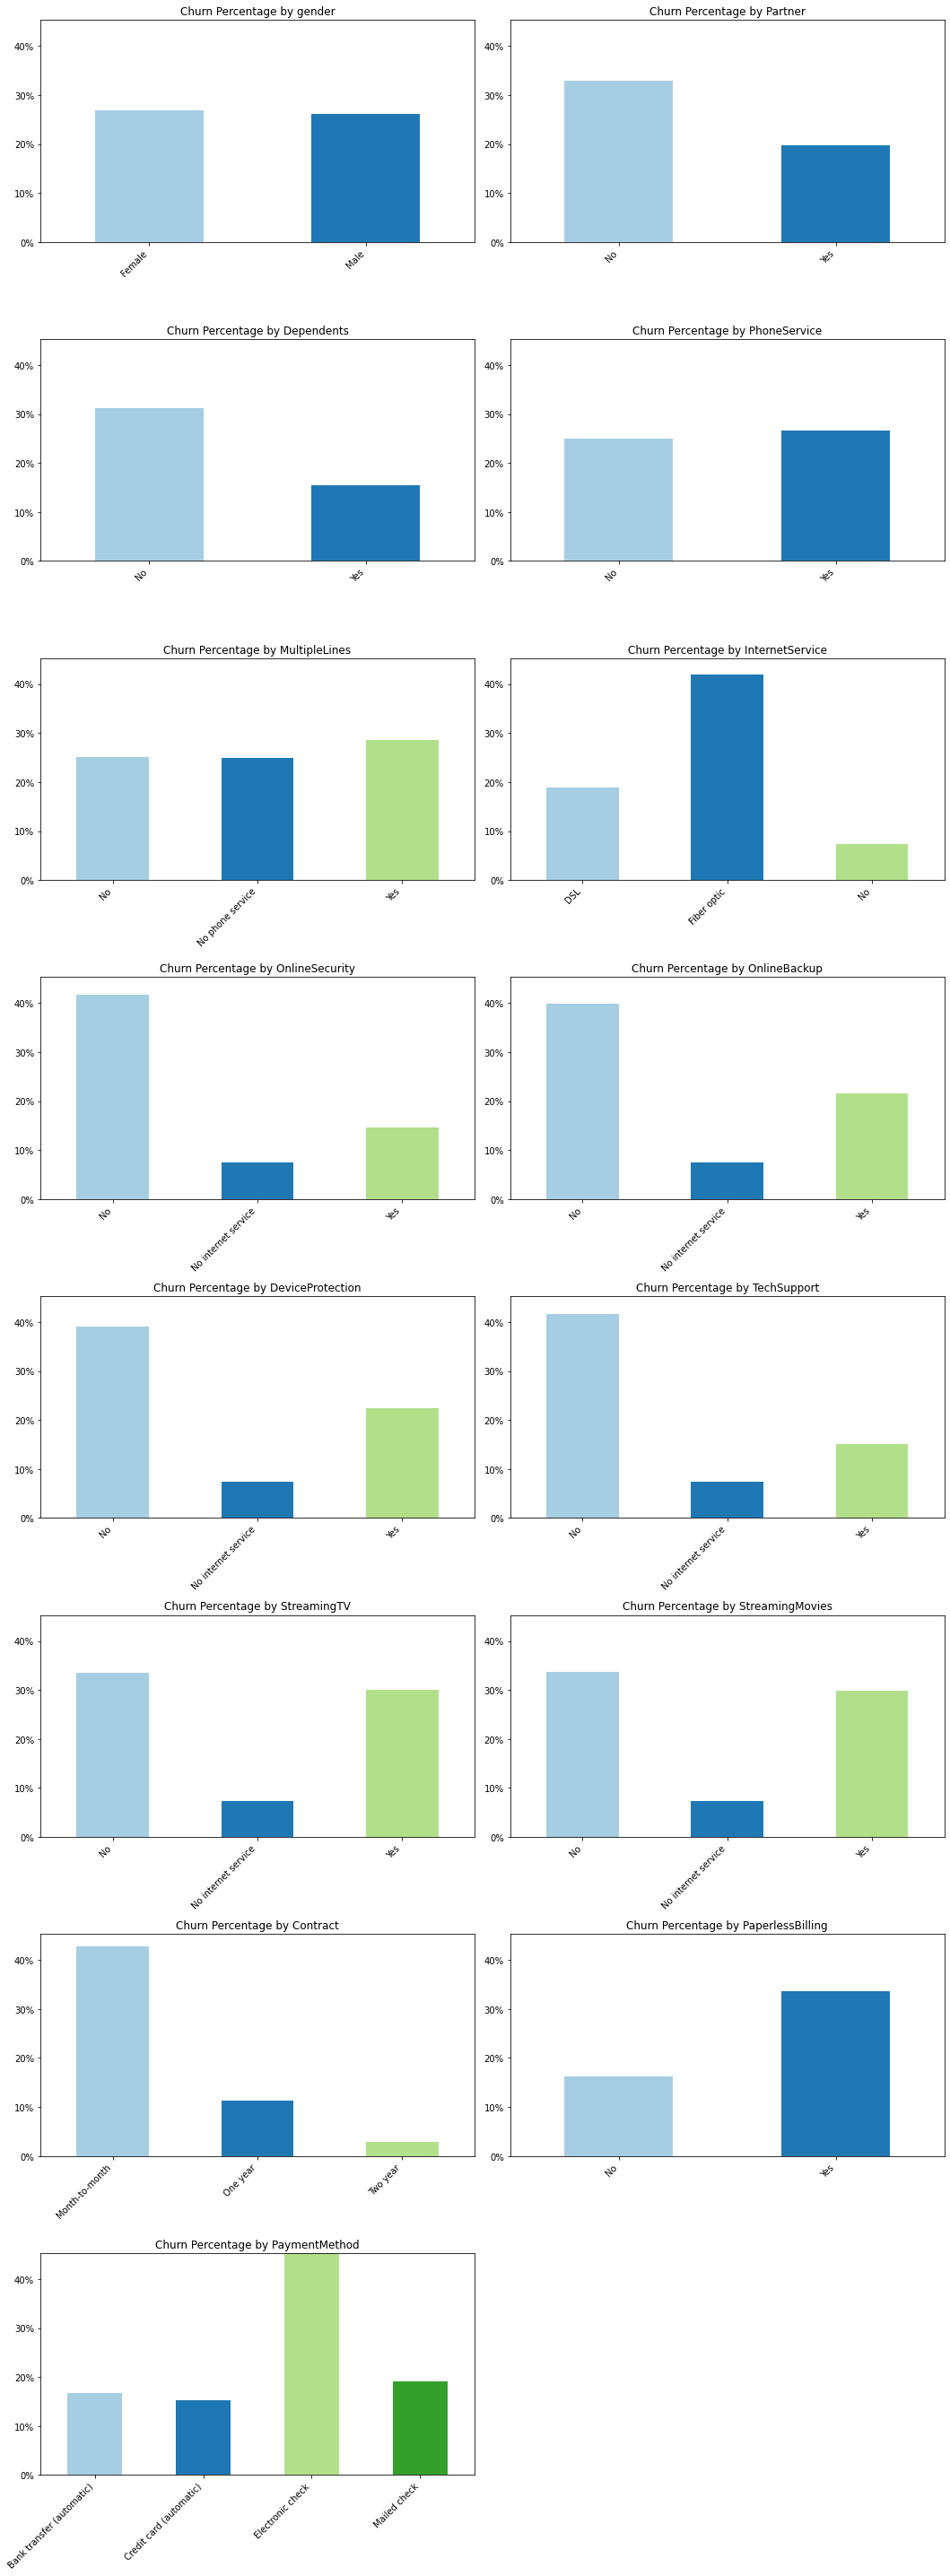

In [15]:
categorical_columns = df.select_dtypes(['category']).columns

num_plots = len(categorical_columns) - 1  
fig_rows = np.ceil(num_plots / 2).astype(int)  

fig, axes = plt.subplots(fig_rows, 2, figsize=(15, 5*fig_rows))
current_ax = 0

def percentage_formatter(x, pos):
    """Format y-axis values as percentages."""
    return '{:.0f}%'.format(x*100)

max_values = []
for col in categorical_columns:
    if col != 'Churn':  
        churn_percentage = df.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean())
        max_values.append(churn_percentage.max())
max_y = max(max_values)

for col in categorical_columns:
    if col != 'Churn':  
        churn_percentage = df.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean())

        ax_row = current_ax // 2
        ax_col = current_ax % 2

        # Plot
        churn_percentage.plot(kind='bar', ax=axes[ax_row, ax_col], color=plt.cm.Paired.colors)
        axes[ax_row, ax_col].set_title(f'Churn Percentage by {col}')
        axes[ax_row, ax_col].set_ylabel('')  
        axes[ax_row, ax_col].set_xlabel('')  
        axes[ax_row, ax_col].set_ylim(0, max_y)  
        axes[ax_row, ax_col].yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        
        axes[ax_row, ax_col].set_xticklabels(axes[ax_row, ax_col].get_xticklabels(), rotation=45, ha='right')

        current_ax += 1

if num_plots % 2 != 0:
    fig.delaxes(axes[ax_row, 1])

plt.tight_layout()
plt.show()

### Examine Correlation to Churn

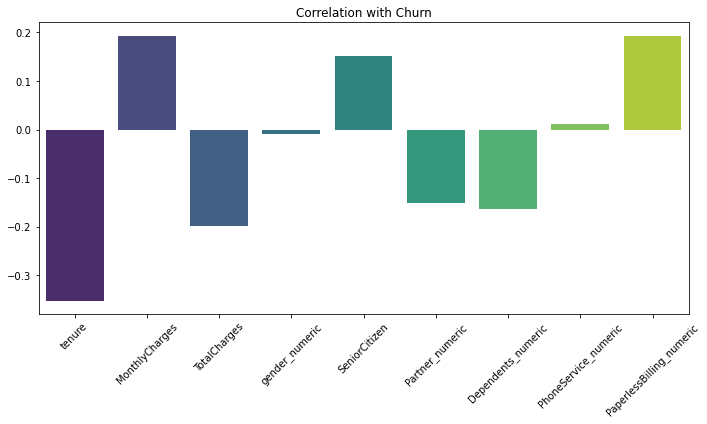

In [16]:
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in binary_columns:
    df[col + "_numeric"] = df[col].cat.codes

correlation_with_churn_binary = df.drop('customerID', axis=1).corr()['Churn_binary'].sort_values(ascending=False)

features_of_interest = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_numeric', 'SeniorCitizen', 'Partner_numeric', 'Dependents_numeric', 'PhoneService_numeric', 'PaperlessBilling_numeric']

filtered_correlations = correlation_with_churn_binary[features_of_interest]


plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_correlations.index, y=filtered_correlations.values, palette='viridis')
plt.title('Correlation with Churn')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
correlation_with_churn_binary

Churn_binary                1.000000
MonthlyCharges              0.193356
PaperlessBilling_numeric    0.191825
SeniorCitizen               0.150889
PhoneService_numeric        0.011942
gender_numeric             -0.008612
Partner_numeric            -0.150448
Dependents_numeric         -0.164221
TotalCharges               -0.199428
tenure                     -0.352229
Name: Churn_binary, dtype: float64

### Correlations

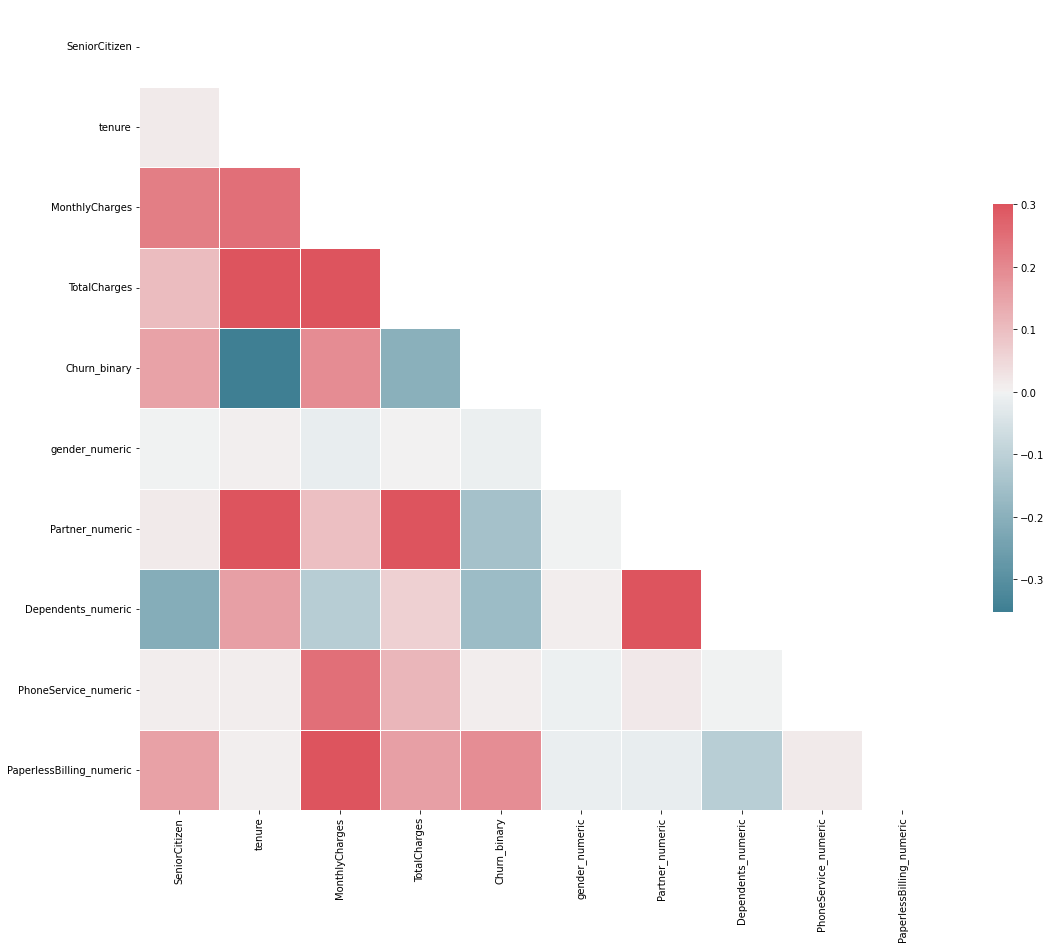

In [18]:
# Correlation Matrix
corr = df.drop('customerID', axis=1).corr()

mask = np.zeros_like(corr, dtype=bool)  
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Find Top 5 Correlations with `Churn_binary`

In [19]:
churn_correlations = corr['Churn_binary'].drop('Churn_binary').abs()

n = 5
top_n_correlations = churn_correlations.nlargest(n)

print(top_n_correlations)

tenure                      0.352229
TotalCharges                0.199428
MonthlyCharges              0.193356
PaperlessBilling_numeric    0.191825
Dependents_numeric          0.164221
Name: Churn_binary, dtype: float64


### Compare Tenure to Categorical Variables

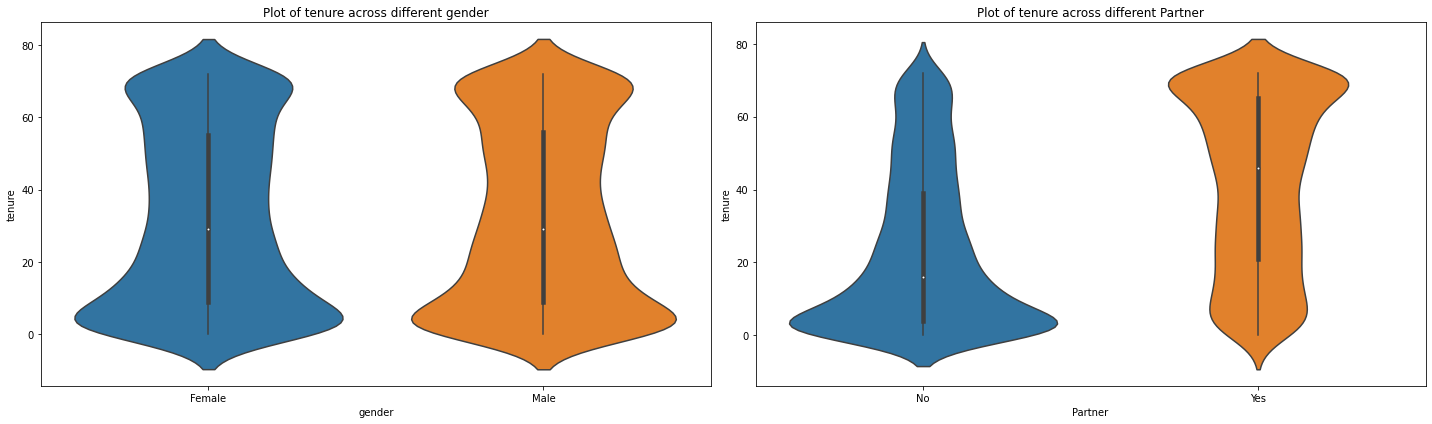

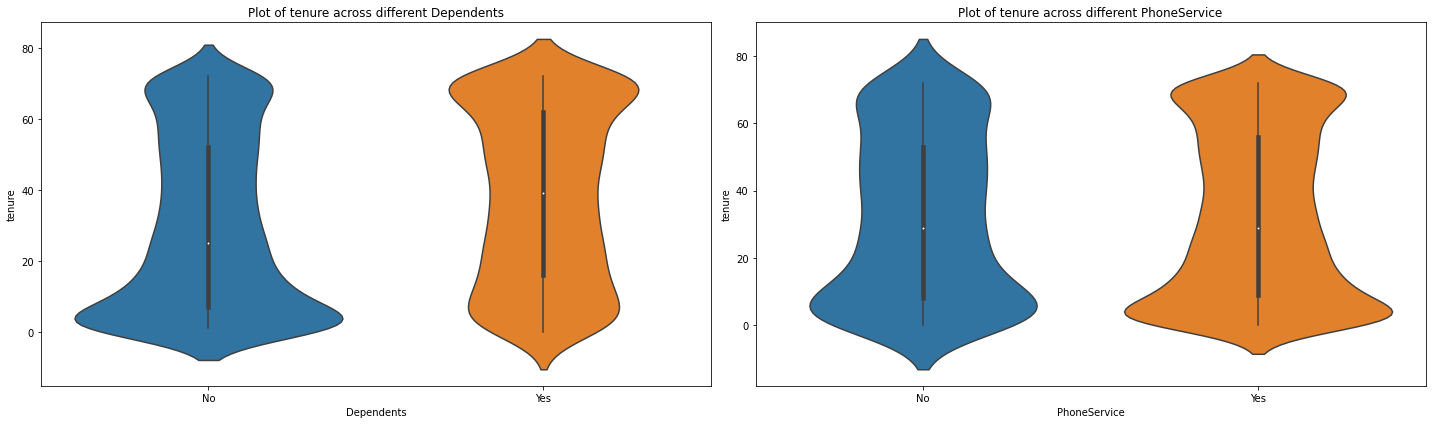

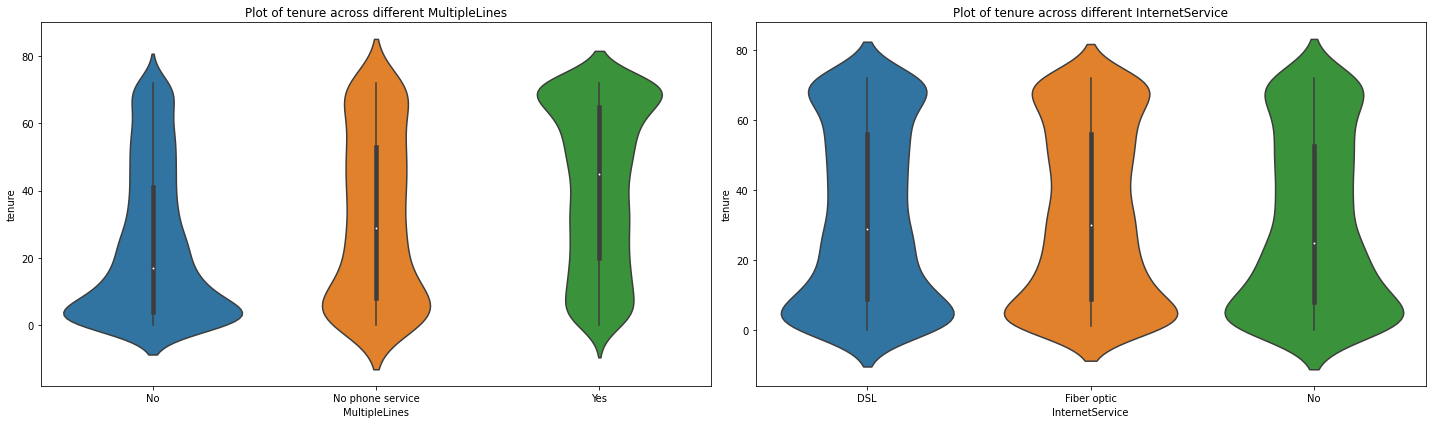

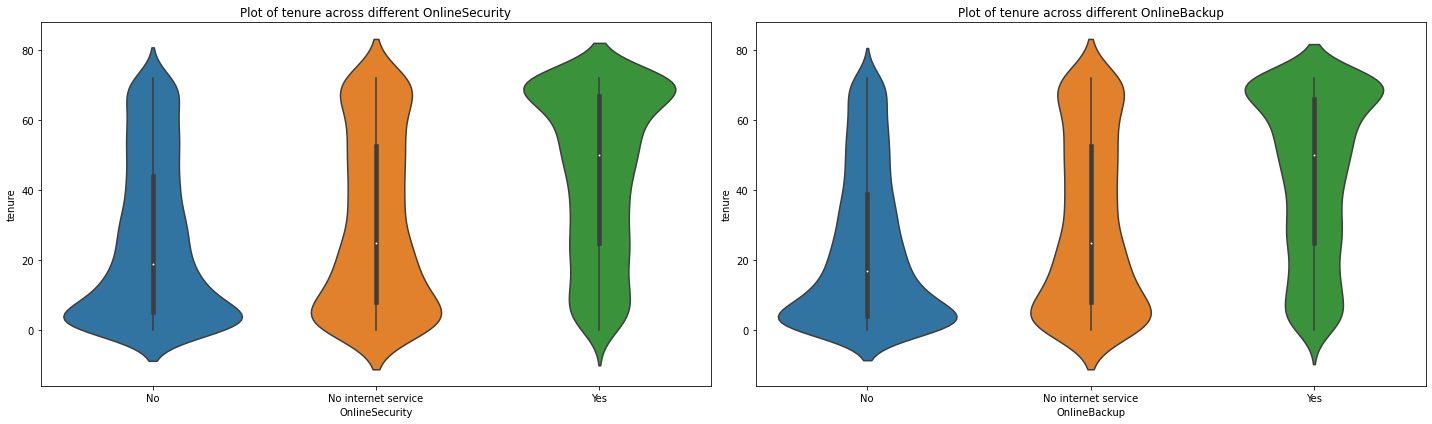

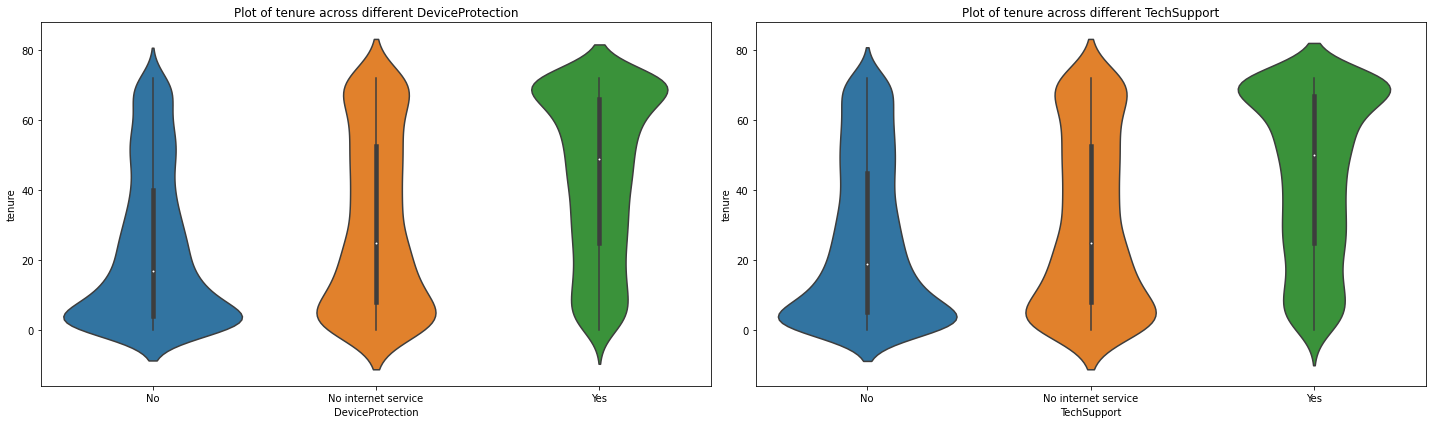

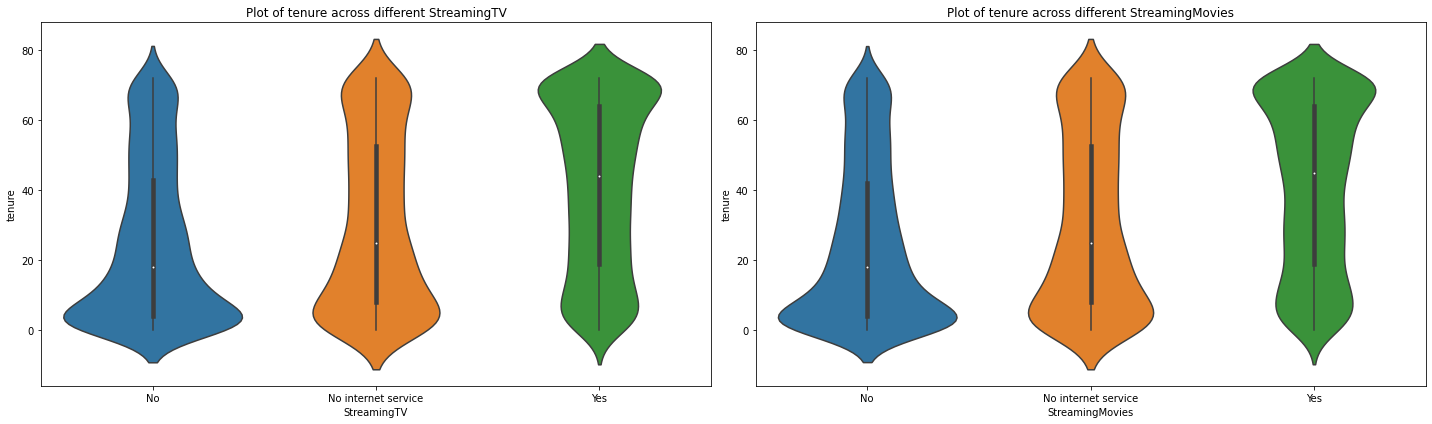

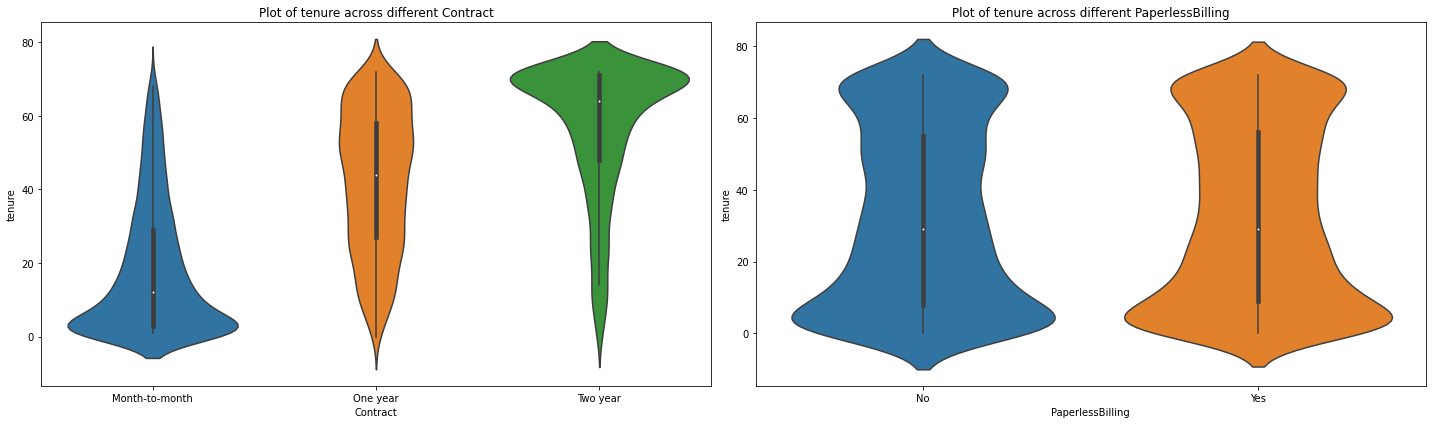

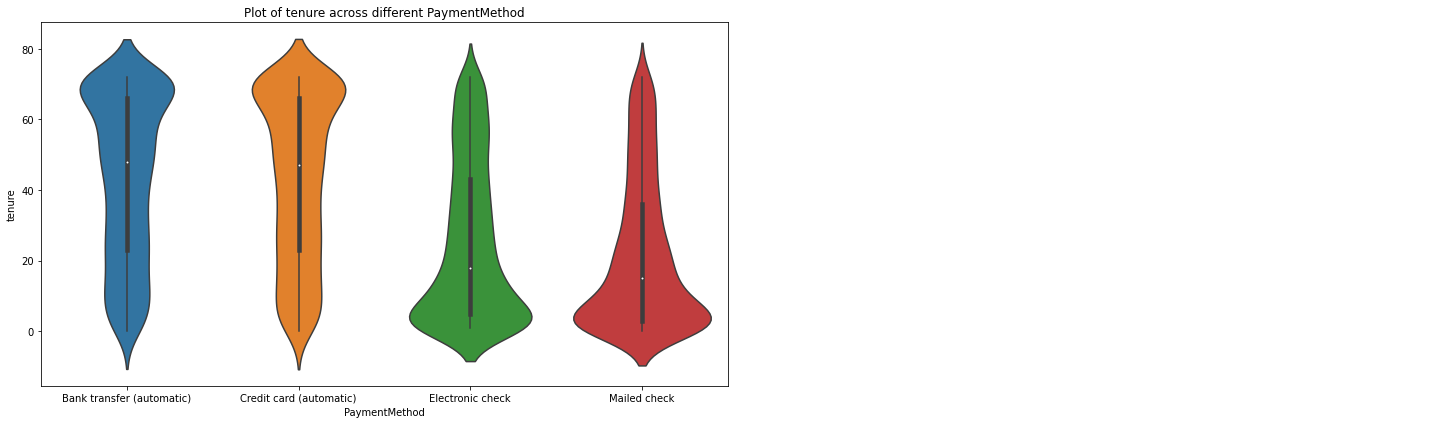

In [20]:
categorical_cols = df.select_dtypes(include=['category']).columns

# Exclude 'Churn' and 'tenure' 
categorical_cols = [col for col in categorical_cols if col not in ['Churn', 'tenure']]

n_cols = 2
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

for i in range(n_rows):
    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(20, 6))
    for j in range(n_cols):
        col_index = i * n_cols + j
        if col_index < len(categorical_cols):
            col = categorical_cols[col_index]
            sns.violinplot(x=col, y='tenure', data=df, ax=axes[j])
            axes[j].set_title(f'Plot of tenure across different {col}')
        else:
            # If there's no data for this subplot, remove it
            axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


### Examine Multicollinearity

In [21]:
# Drop non-numeric columns
X = df.drop(['Churn', 'customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 
             'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
             'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'], axis=1)

# Handle missing values 
X = X.fillna(X.mean())

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                   Variable        VIF
2            MonthlyCharges  15.849111
3              TotalCharges  13.186957
1                    tenure  10.563043
8      PhoneService_numeric   7.982383
9  PaperlessBilling_numeric   2.841429
6           Partner_numeric   2.815377
7        Dependents_numeric   1.923532
5            gender_numeric   1.921747
4              Churn_binary   1.791580
0             SeniorCitizen   1.336549


### Drop `TotalCharges` to Reduce Multicollinearity

In [22]:
# Drop non-numeric columns
X = X.drop(['TotalCharges'], axis=1)

# Handle missing values (using mean for this example, but you could also consider median or mode)
X = X.fillna(X.mean())

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                   Variable       VIF
2            MonthlyCharges  8.060740
7      PhoneService_numeric  6.016842
1                    tenure  3.771165
5           Partner_numeric  2.814820
8  PaperlessBilling_numeric  2.793307
6        Dependents_numeric  1.909050
4            gender_numeric  1.883783
3              Churn_binary  1.707811
0             SeniorCitizen  1.334386


# Reset & Clean Data for Modeling

In [23]:
df = df_load.copy()
# Drop 'TotalCharges'
df = df.drop(columns=['TotalCharges'])

# Temporarily remove 'customerID'
df_temp = df.drop(columns=['customerID'])

# Create dummy variables 
df_temp = pd.get_dummies(df_temp, columns=df_temp.select_dtypes(['object']).columns.drop('Churn'), drop_first=True)

# Change 'Churn' to binary
df_temp['Churn'] = df_temp['Churn'].map({'Yes': 1, 'No': 0})

# Add 'customerID' back to df_temp
df_temp['customerID'] = df['customerID']

# Reorder columns to have 'customerID' at the front
cols = ['customerID'] + [col for col in df_temp if col != 'customerID']
df_temp = df_temp[cols]

# Reorder columns to have 'Churn' at the end
cols = [col for col in df_temp if col != 'Churn'] + ['Churn']
df_temp = df_temp[cols]

# Display the transformed dataframe with 'customerID'
df = df_temp.copy()


# Divide into Test & Train Sections

In [24]:
X = df_temp.drop('Churn', axis=1)

y = df_temp['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

customerID_train = X_train['customerID']
customerID_test = X_test['customerID']

X_train = X_train.drop('customerID', axis=1)
X_test = X_test.drop('customerID', axis=1)



0    0.734686
1    0.265314
Name: Churn, dtype: float64
0    0.734501
1    0.265499
Name: Churn, dtype: float64


# Feature Scaling and Selection

In [25]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


# Logistic Regression Model

In [26]:
model = LogisticRegression(solver='liblinear')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1552
           1       0.65      0.55      0.59       561

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.80      2113

Best hyperparameters: {'C': 10, 'penalty': 'l1'}


In [27]:
best_model = grid_search.best_estimator_

print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(best_model.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Recall of logistic regression classifier on test set: {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred)))
print('ROC/AUC of logistic regression classifier on test set: {:.2f}'.format(roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])))
print('F1 Scoreof logistic regression classifier: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy of logistic regression classifier on train set: 0.80
Accuracy of logistic regression classifier on test set: 0.80
Recall of logistic regression classifier on test set: 0.55
Precision of logistic regression classifier on test set: 0.65
ROC/AUC of logistic regression classifier on test set: 0.84
F1 Scoreof logistic regression classifier: 0.59


### Plotting the Mean Cross-Validated Score from GridSearch

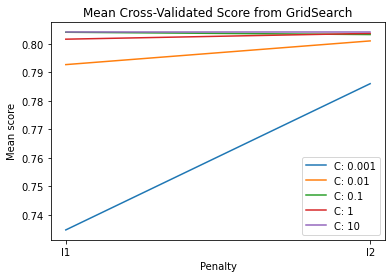

In [28]:
mean_scores = grid_search.cv_results_['mean_test_score']
params = list(grid_search.cv_results_['params'])

scores_array = np.array(mean_scores).reshape(len(param_grid['C']), len(param_grid['penalty']))
for ind, i in enumerate(param_grid['C']):
    plt.plot(param_grid['penalty'], scores_array[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Penalty')
plt.ylabel('Mean score')
plt.title('Mean Cross-Validated Score from GridSearch')
plt.show()

### ROC Curve

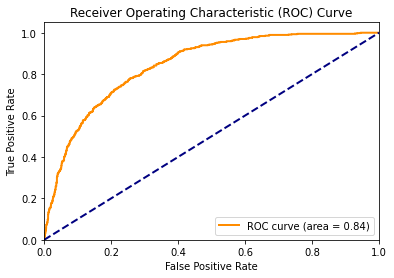

In [29]:
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

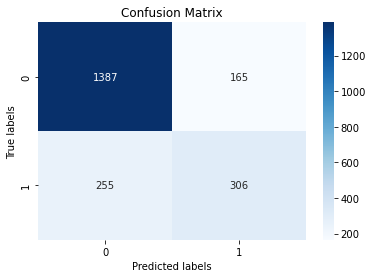

[[1387  165]
 [ 255  306]]


In [30]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm)

# XGBoost Model

In [31]:
model = XGBClassifier( eval_metric='logloss') #use_label_encoder=False,

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1.0]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1552
           1       0.67      0.49      0.57       561

    accuracy                           0.80      2113
   macro avg       0.75      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113

Best hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [32]:
best_model = grid_search.best_estimator_
print('Accuracy of XGBoost classifier on train set: {:.2f}'.format(best_model.score(X_train, y_train)))
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Recall of XGBoost classifier on test set: {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision of XGBoost classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred)))
print('ROC/AUC of XGBoost classifier on test set: {:.2f}'.format(roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])))
print('F1 Scoreof XGBoost classifier: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy of XGBoost classifier on train set: 0.82
Accuracy of XGBoost classifier on test set: 0.80
Recall of XGBoost classifier on test set: 0.49
Precision of XGBoost classifier on test set: 0.67
ROC/AUC of XGBoost classifier on test set: 0.84
F1 Scoreof XGBoost classifier: 0.57


### Plotting the Mean Cross-Validated Score from GridSearch

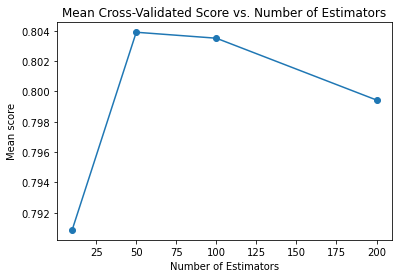

In [34]:
params = grid_search.cv_results_['params']
mean_scores = grid_search.cv_results_['mean_test_score']

unique_scores_n_estimators = []

for n_estimator in param_grid['n_estimators']:
    scores_for_this_n_estimator = [mean_score for param, mean_score in zip(params, mean_scores) 
                                   if param['max_depth'] == grid_search.best_params_['max_depth'] 
                                   and param['learning_rate'] == grid_search.best_params_['learning_rate']
                                   and param['n_estimators'] == n_estimator]
    unique_scores_n_estimators.append(np.mean(scores_for_this_n_estimator))

plt.plot(param_grid['n_estimators'], unique_scores_n_estimators, '-o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean score')
plt.title('Mean Cross-Validated Score vs. Number of Estimators')
plt.show()

### ROC Curve

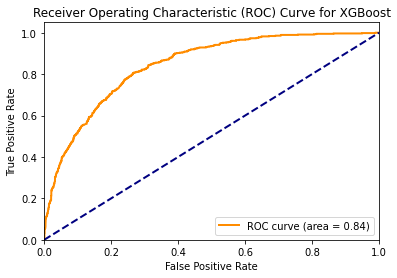

In [35]:
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

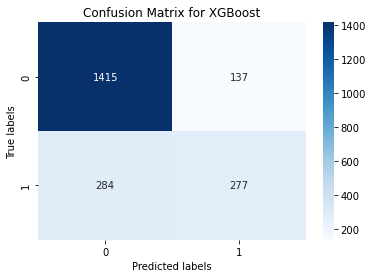

[[1415  137]
 [ 284  277]]


In [36]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()
print(cm)

# Random Forest

In [37]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 100, 200],   # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required to be at a leaf node
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1552
           1       0.66      0.50      0.57       561

    accuracy                           0.80      2113
   macro avg       0.75      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [38]:
best_model = grid_search.best_estimator_

print('Accuracy of random forest classifier on train set: {:.2f}'.format(best_model.score(X_train, y_train)))
print('Accuracy of random forest classifier on test set: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Recall of random forest classifier on test set: {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision of random forest classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred)))
print('ROC/AUC of random forest classifier on test set: {:.2f}'.format(roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])))
print('F1 Scoreof random forest classifier: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy of random forest classifier on train set: 0.84
Accuracy of random forest classifier on test set: 0.80
Recall of random forest classifier on test set: 0.50
Precision of random forest classifier on test set: 0.66
ROC/AUC of random forest classifier on test set: 0.84
F1 Scoreof random forest classifier: 0.57


### Plotting the Mean Cross-Validated Score from GridSearch

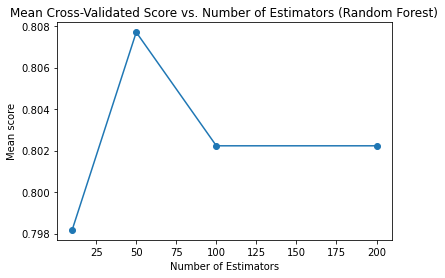

In [39]:
mean_scores = grid_search.cv_results_['mean_test_score']
params = list(grid_search.cv_results_['params'])

scores_n_estimators = [mean_score for param, mean_score in zip(params, mean_scores) if param['max_depth'] == grid_search.best_params_['max_depth'] and param['min_samples_split'] == grid_search.best_params_['min_samples_split'] and param['min_samples_leaf'] == grid_search.best_params_['min_samples_leaf']]

plt.plot(param_grid['n_estimators'], scores_n_estimators, '-o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean score')
plt.title('Mean Cross-Validated Score vs. Number of Estimators (Random Forest)')
plt.show()

### ROC Curve

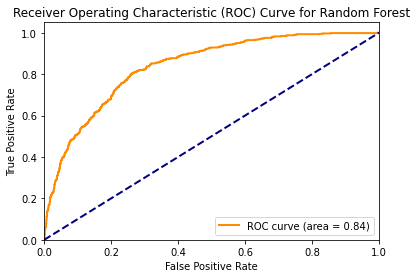

In [40]:
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

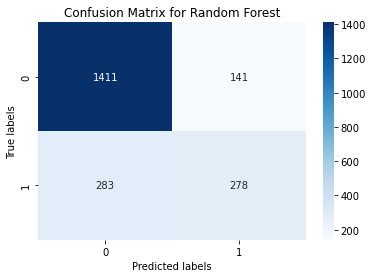

[[1411  141]
 [ 283  278]]


In [41]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()
print(cm)

# Summary Observations

1. **Accuracy**: All models perform similarly on the test set with around 0.80 accuracy.<br><br>

2. **Recall**: Logistic Regression has the highest recall (0.55), suggesting it correctly identifies a slightly higher proportion of positive classes than XGBoost (0.49) or Random Forest (0.50).<br><br>

3. **Precision**: XGBoost has the highest precision (0.67), suggesting that when it predicts the positive class, it is correct more often than Logistic Regression (0.65) or Random Forest (0.66).<br><br>

4. **F1 Score**: F1 score, which balances precision and recall, is slightly higher for Logistic Regression (0.59) than for the other two models (0.57).<br><br>

5. **ROC/AUC**: All models have an AUC of 0.84, suggesting they all perform similarly when ranking predictions by confidence.<br><br>

6. **Confusion Matrix**: The confusion matrices show that all models have more false negatives than false positives. This is consistent with the recall values for each model.<br><br>

7. **Calculating Strain**: XGBoost significantly demanded more computational resources to generate the model.